<a href="https://colab.research.google.com/github/NilakshanRaveendran/bilingual-voice-translation-research/blob/main/Test_Translation_(NMT)_%2B_Translation_Evaluation_%2B_Prepare_for_TTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install transformers datasets sentencepiece evaluate sacrebleu pandas matplotlib sacremoses jiwer

from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 110.2 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
vfrom datasets import load_dataset

ds = load_dataset("opus_books", "en-es")  # parallel text
print(ds)

# Use small subset for fast training (change sizes if you have GPU time)
train_ds = ds["train"].shuffle(seed=42).select(range(5000))
val_ds   = ds["train"].shuffle(seed=123).select(range(500))  # quick validation

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 93470
    })
})


In [ ]:
from transformers import MarianMTModel, MarianTokenizer

MODEL_NAME = "Helsinki-NLP/opus-mt-en-es"
tokenizer = MarianTokenizer.from_pretrained(MODEL_NAME)
model = MarianMTModel.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [ ]:
max_len = 128

def preprocess(batch):
    # Extract 'en' and 'es' sentences from the list of translation dictionaries
    src = [item["en"] for item in batch["translation"]]
    tgt = [item["es"] for item in batch["translation"]]
    model_in = tokenizer(src, max_length=max_len, truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(tgt, max_length=max_len, truncation=True)
    model_in["labels"] = labels["input_ids"]
    return model_in

train_tok = train_ds.map(preprocess, batched=True, remove_columns=train_ds.column_names)
val_tok   = val_ds.map(preprocess, batched=True, remove_columns=val_ds.column_names)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4174: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
import evaluate
import numpy as np
from transformers import DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
import os

bleu = evaluate.load("sacrebleu")

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    # Replace -100 with pad_token_id for decoding
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    pred_str = tokenizer.batch_decode(preds, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # sacrebleu expects list of references (list of list)
    bleu_score = bleu.compute(predictions=pred_str, references=[[l] for l in label_str])
    return {"bleu": bleu_score["score"]}

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

BASE_DIR = "/content/drive/MyDrive/bilingual_voice_translation"
LOG_DIR  = f"{BASE_DIR}/nmt_logs"
OUT_DIR  = f"{BASE_DIR}/nmt_model"
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

args = Seq2SeqTrainingArguments(
    output_dir=OUT_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,          # increase later (3–5) if time
    predict_with_generate=True,
    logging_dir=LOG_DIR,
    logging_steps=50,
    report_to="none"
)

trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-2381683981.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
train_result = trainer.train()
eval_result = trainer.evaluate()

print("Final eval:", eval_result)

# Save the model to Drive
trainer.save_model(OUT_DIR)
tokenizer.save_pretrained(OUT_DIR)
print("✅ Saved model to:", OUT_DIR)

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.


Epoch,Training Loss,Validation Loss,Bleu
1,2.252800,2.135261,20.733761
2,1.898100,2.112850,20.885377


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[65000]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Final eval: {'eval_loss': 2.1128499507904053, 'eval_bleu': 20.88537689665471, 'eval_runtime': 50.4908, 'eval_samples_per_second': 9.903, 'eval_steps_per_second': 1.248, 'epoch': 2.0}
✅ Saved model to: /content/drive/MyDrive/bilingual_voice_translation/nmt_model


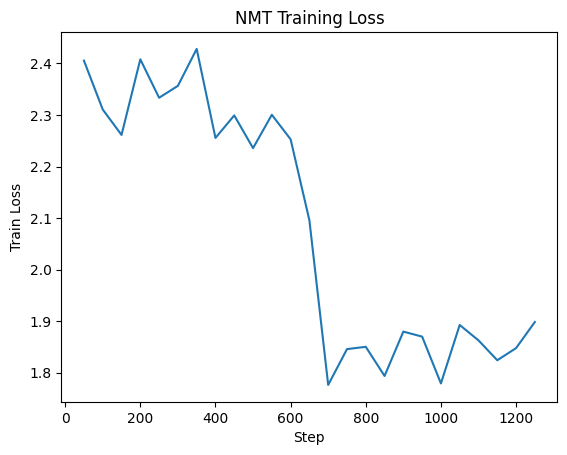

✅ Saved: /content/drive/MyDrive/bilingual_voice_translation/results/nmt_train_loss.png


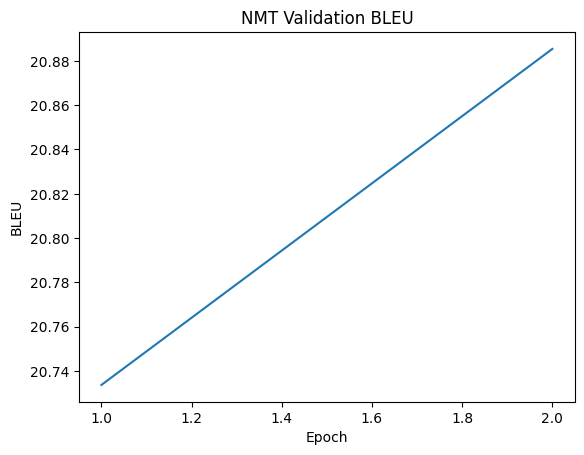

✅ Saved: /content/drive/MyDrive/bilingual_voice_translation/results/nmt_val_bleu.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Trainer keeps logs here
logs = trainer.state.log_history
df_logs = pd.DataFrame(logs)

# Keep only rows that have useful fields
df_logs.to_csv(f"{BASE_DIR}/results/nmt_training_logs.csv", index=False)

# Plot train loss over steps
if "loss" in df_logs.columns:
    df_loss = df_logs.dropna(subset=["loss", "step"])
    plt.figure()
    plt.plot(df_loss["step"], df_loss["loss"])
    plt.xlabel("Step")
    plt.ylabel("Train Loss")
    plt.title("NMT Training Loss")
    loss_png = f"{BASE_DIR}/results/nmt_train_loss.png"
    plt.savefig(loss_png, dpi=200, bbox_inches="tight")
    plt.show()
    print("✅ Saved:", loss_png)

# Plot BLEU over epochs (from eval logs)
if "eval_bleu" in df_logs.columns:
    df_bleu = df_logs.dropna(subset=["eval_bleu", "epoch"])
    plt.figure()
    plt.plot(df_bleu["epoch"], df_bleu["eval_bleu"])
    plt.xlabel("Epoch")
    plt.ylabel("BLEU")
    plt.title("NMT Validation BLEU")
    bleu_png = f"{BASE_DIR}/results/nmt_val_bleu.png"
    plt.savefig(bleu_png, dpi=200, bbox_inches="tight")
    plt.show()
    print("✅ Saved:", bleu_png)

In [ ]:
import pandas as pd
import torch
from transformers import MarianMTModel, MarianTokenizer

ASR_CSV = f"{BASE_DIR}/results/asr_segments_with_refs.csv"
df_asr = pd.read_csv(ASR_CSV)

# Load fine-tuned model from Drive
ft_tokenizer = MarianTokenizer.from_pretrained(OUT_DIR)
ft_model = MarianMTModel.from_pretrained(OUT_DIR)

def translate_batch(texts, tokenizer, model, max_len=256):
    texts = [("" if pd.isna(t) else str(t).strip()) for t in texts]
    batch = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=max_len)
    with torch.no_grad():
        gen = model.generate(**batch, max_new_tokens=128)
    return tokenizer.batch_decode(gen, skip_special_tokens=True)

df_en = df_asr[df_asr["language_detected"].astype(str).str.lower().str.startswith("en")].copy()
texts = df_en["asr_text"].tolist()

BATCH_SIZE = 16
out = []
for i in range(0, len(texts), BATCH_SIZE):
    out.extend(translate_batch(texts[i:i+BATCH_SIZE], ft_tokenizer, ft_model))

df_en["spanish_text"] = out

save_path = f"{BASE_DIR}/results/nmt_en_to_es_finetuned.csv"
df_en.to_csv(save_path, index=False)
print("✅ Saved:", save_path)

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


✅ Saved: /content/drive/MyDrive/bilingual_voice_translation/results/nmt_en_to_es_finetuned.csv


#Back-Translation Consistency Check

In [ ]:
BASE_DIR = "/content/drive/MyDrive/bilingual_voice_translation"
CSV_PATH = f"{BASE_DIR}/results/asr_segments_with_refs.csv"

df = pd.read_csv(CSV_PATH)

# Keep only English ASR rows
df_en = df[df["language_detected"].str.startswith("en")].copy()

print("Rows for back-translation:", len(df_en))
df_en[["segment_file", "asr_text"]].head()

Rows for back-translation: 103


,segment_file,asr_text
0,common_voice_es_18306544.mp3_seg_0.wav,But are there people available?
1,common_voice_es_18306545.mp3_seg_0.wav,The priority is to ensure the safety of the c...
2,common_voice_es_18306546.mp3_seg_0.wav,"Hey, Brunette!"
3,common_voice_es_18306547.mp3_seg_0.wav,"It's obvious that you don't care anymore, but..."
4,common_voice_es_18306548.mp3_seg_0.wav,"There, juvenile intruders, I repeat myself."


In [ ]:
from transformers import MarianMTModel, MarianTokenizer

# English → Spanish
en_es_model = "Helsinki-NLP/opus-mt-en-es"
tok_en_es = MarianTokenizer.from_pretrained(en_es_model)
mod_en_es = MarianMTModel.from_pretrained(en_es_model)

# Spanish → English
es_en_model = "Helsinki-NLP/opus-mt-es-en"
tok_es_en = MarianTokenizer.from_pretrained(es_en_model)
mod_es_en = MarianMTModel.from_pretrained(es_en_model)

print("✅ NMT models loaded")

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

✅ NMT models loaded


In [ ]:
import torch

def translate(texts, tokenizer, model):
    batch = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        out = model.generate(**batch, max_new_tokens=128)
    return tokenizer.batch_decode(out, skip_special_tokens=True)

In [ ]:
BATCH = 16
orig_texts = df_en["asr_text"].tolist()

# Step 1: EN → ES
spanish = []
for i in range(0, len(orig_texts), BATCH):
    spanish.extend(translate(orig_texts[i:i+BATCH], tok_en_es, mod_en_es))

# Step 2: ES → EN
back_english = []
for i in range(0, len(spanish), BATCH):
    back_english.extend(translate(spanish[i:i+BATCH], tok_es_en, mod_es_en))

df_en["spanish_text"] = spanish
df_en["back_translated_english"] = back_english

df_en[["asr_text", "back_translated_english"]].head()

,asr_text,back_translated_english
0,But are there people available?,But are there people available?
1,The priority is to ensure the safety of the c...,The priority is to ensure the safety of citizens.
2,"Hey, Brunette!","Hey, Morena!"
3,"It's obvious that you don't care anymore, but...","You obviously don't care anymore, but..."
4,"There, juvenile intruders, I repeat myself.","There, juvenile intruders, I repeat myself."


In [ ]:
import evaluate

bleu = evaluate.load("sacrebleu")

score = bleu.compute(
    predictions=df_en["back_translated_english"].tolist(),
    references=[[t] for t in df_en["asr_text"].tolist()]
)

print("🔹 Back-translation BLEU:", score["score"])

🔹 Back-translation BLEU: 60.9821713928309


In [ ]:
OUT_PATH = f"{BASE_DIR}/results/back_translation_eval.csv"
df_en.to_csv(OUT_PATH, index=False)

print("✅ Saved:", OUT_PATH)

✅ Saved: /content/drive/MyDrive/bilingual_voice_translation/results/back_translation_eval.csv


#Plots you’ll get (all saved as PNG)

In [ ]:
import os
import pandas as pd

BASE_DIR = "/content/drive/MyDrive/bilingual_voice_translation"
IN_CSV   = f"{BASE_DIR}/results/back_translation_eval.csv"
OUT_DIR  = f"{BASE_DIR}/results/plots"
os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(IN_CSV)
print("Loaded:", IN_CSV)
print("Rows:", len(df))
print("Columns:", df.columns.tolist())

df.head()

Loaded: /content/drive/MyDrive/bilingual_voice_translation/results/back_translation_eval.csv
Rows: 103
Columns: ['segment_file', 'clip', 'language_detected', 'asr_text', 'reference_text', 'spanish_text', 'back_translated_english']


,segment_file,clip,language_detected,asr_text,reference_text,spanish_text,back_translated_english
0,common_voice_es_18306544.mp3_seg_0.wav,common_voice_es_18306544.mp3,en,But are there people available?,but are their people available,¿Pero hay gente disponible?,But are there people available?
1,common_voice_es_18306545.mp3_seg_0.wav,common_voice_es_18306545.mp3,en,The priority is to ensure the safety of the c...,the priority is to ensure the safety of the ci...,La prioridad es garantizar la seguridad de los...,The priority is to ensure the safety of citizens.
2,common_voice_es_18306546.mp3_seg_0.wav,common_voice_es_18306546.mp3,en,"Hey, Brunette!",hey brunette,"¡Oye, Morena!","Hey, Morena!"
3,common_voice_es_18306547.mp3_seg_0.wav,common_voice_es_18306547.mp3,en,"It's obvious that you don't care anymore, but...",it's obvious that you don't care anymore but,"Es obvio que ya no te importa, pero...","You obviously don't care anymore, but..."
4,common_voice_es_18306548.mp3_seg_0.wav,common_voice_es_18306548.mp3,en,"There, juvenile intruders, I repeat myself.",there juvenile intruders i repeat myself recov...,"Allí, intrusos juveniles, me repito.","There, juvenile intruders, I repeat myself."


Sentence-level similarity score distribution

In [ ]:
import re
from jiwer import wer

def clean_text(s: str) -> str:
    if pd.isna(s):
        return ""
    s = str(s).lower().strip()
    s = re.sub(r"[^a-z0-9\s]", " ", s)   # remove punctuation
    s = re.sub(r"\s+", " ", s).strip()  # normalize spaces
    return s

orig = df["asr_text"].astype(str).tolist()
back = df["back_translated_english"].astype(str).tolist()

scores = []
wer_vals = []
for o, b in zip(orig, back):
    o2 = clean_text(o)
    b2 = clean_text(b)
    w = wer(o2, b2) if (o2 and b2) else 1.0
    wer_vals.append(w)
    scores.append(1.0 - w)  # similarity

df["wer_clean"] = wer_vals
df["bt_similarity"] = scores

print("✅ Avg back-translation similarity (1-WER):", df["bt_similarity"].mean())
df[["asr_text","back_translated_english","bt_similarity"]].head()

✅ Avg back-translation similarity (1-WER): 0.7699430828071606


,asr_text,back_translated_english,bt_similarity
0,But are there people available?,But are there people available?,1.0
1,The priority is to ensure the safety of the c...,The priority is to ensure the safety of citizens.,0.9
2,"Hey, Brunette!","Hey, Morena!",0.5
3,"It's obvious that you don't care anymore, but...","You obviously don't care anymore, but...",0.5
4,"There, juvenile intruders, I repeat myself.","There, juvenile intruders, I repeat myself.",1.0


Histogram

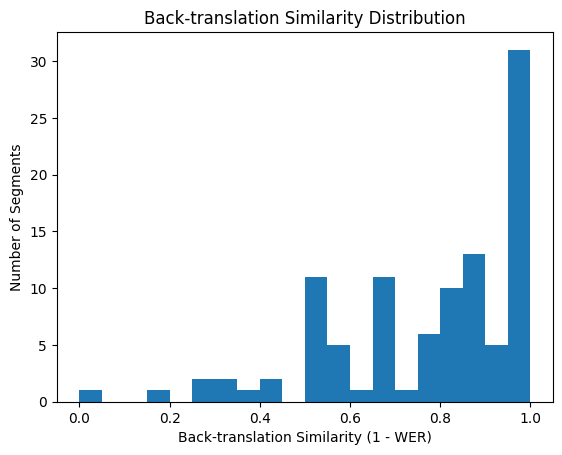

✅ Saved: /content/drive/MyDrive/bilingual_voice_translation/results/plots/bt_similarity_hist.png


In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df["bt_similarity"], bins=20)
plt.xlabel("Back-translation Similarity (1 - WER)")
plt.ylabel("Number of Segments")
plt.title("Back-translation Similarity Distribution")

p1 = f"{OUT_DIR}/bt_similarity_hist.png"
plt.savefig(p1, dpi=200, bbox_inches="tight")
plt.show()

print("✅ Saved:", p1)

Boxplot: spread of scores (median, outliers)

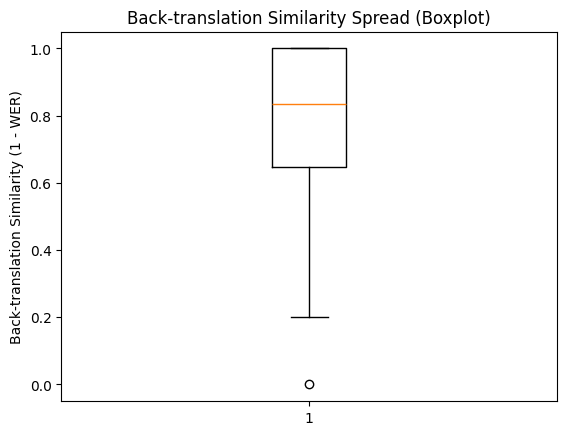

✅ Saved: /content/drive/MyDrive/bilingual_voice_translation/results/plots/bt_similarity_boxplot.png


In [ ]:
plt.figure()
plt.boxplot(df["bt_similarity"].dropna(), vert=True)
plt.ylabel("Back-translation Similarity (1 - WER)")
plt.title("Back-translation Similarity Spread (Boxplot)")

p2 = f"{OUT_DIR}/bt_similarity_boxplot.png"
plt.savefig(p2, dpi=200, bbox_inches="tight")
plt.show()

print("✅ Saved:", p2)

Scatter: score vs sentence length (shows where model struggles)

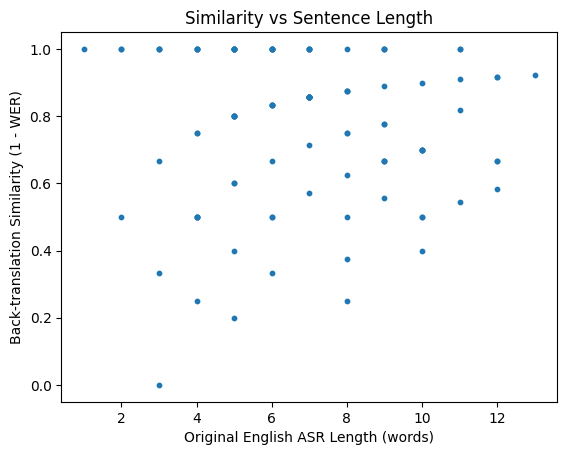

✅ Saved: /content/drive/MyDrive/bilingual_voice_translation/results/plots/bt_similarity_vs_length.png


In [ ]:
df["orig_len_words"] = df["asr_text"].astype(str).apply(lambda x: len(clean_text(x).split()))

plt.figure()
plt.scatter(df["orig_len_words"], df["bt_similarity"], s=10)
plt.xlabel("Original English ASR Length (words)")
plt.ylabel("Back-translation Similarity (1 - WER)")
plt.title("Similarity vs Sentence Length")

p3 = f"{OUT_DIR}/bt_similarity_vs_length.png"
plt.savefig(p3, dpi=200, bbox_inches="tight")
plt.show()

print("✅ Saved:", p3)

In [ ]:
# Keep only useful columns
cols = ["segment_file", "clip", "asr_text", "spanish_text", "back_translated_english", "bt_similarity"]

best = df.sort_values("bt_similarity", ascending=False).head(20)[cols]
worst = df.sort_values("bt_similarity", ascending=True).head(20)[cols]

best_path = f"{OUT_DIR}/bt_best_examples.csv"
worst_path = f"{OUT_DIR}/bt_worst_examples.csv"

best.to_csv(best_path, index=False)
worst.to_csv(worst_path, index=False)

print("✅ Saved best examples:", best_path)
print("✅ Saved worst examples:", worst_path)

✅ Saved best examples: /content/drive/MyDrive/bilingual_voice_translation/results/plots/bt_best_examples.csv
✅ Saved worst examples: /content/drive/MyDrive/bilingual_voice_translation/results/plots/bt_worst_examples.csv
